In [6]:
import cv2 
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [13., 9.]

### Вступление
В данной работе были рассмотрены алгоритмы для решения одной задачи частичной реконсрукции 3D-сцены по изображению. 

На сегодняшний день большое количество задач компьютерного зрения решается в области дополненной или виртуальной реальности. Одна из таких задач $-$ это частичное восстановление 3D-сцены по снимкам, т.е. на входе у алгоритма имеется какое-либо изображение или набор изображений и требуется построить 3D-облако точек, которе бы описывало изображение или интересующую часть этого изображения (в основном за такие части принимаются какие-либо плоские объекты $-$ стены, мебель, дорога, здания и т.д.). В дальнейшем это используется уже внутри AR/VR движков для размещения объектов виртуальной или дополненной реальности на этих восстановленных частях. Пример - на картинке снизу.



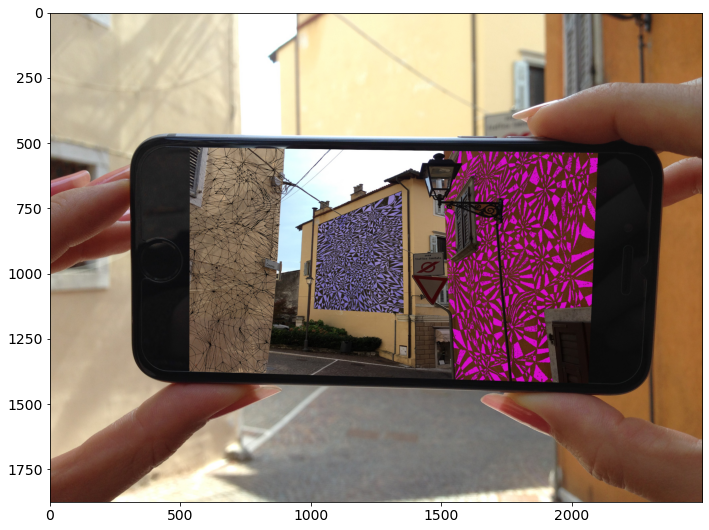

In [10]:
plt.imshow(cv2.cvtColor(cv2.imread("media/ar_example.png"), cv2.COLOR_BGR2RGB));

Особенностью работы является то, что в качестве исходных данных использованы фотографии с улицы. Дело в том, что есть аналогичная задача для помещений, и ключевое отличие данных задач состоит в том, что у задачи в помещении есть готовые датасеты с размеченными плоскоятми и другими данными (пример - на картинке). В связи с этим, для задач в помещении можно использовать модели и методы, которые непосредственно решают данную задачу (можно, например, рассмотреть задачу попиксельной классификации или что-то другое).

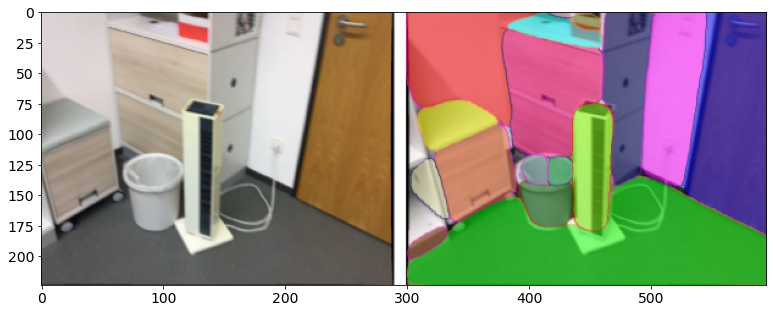

In [11]:
plt.imshow(cv2.cvtColor(cv2.imread("media/indoor.png"), cv2.COLOR_BGR2RGB));

Ниже приведен краткий обзор моделей, которые подходят для непосредственного решения задачи:
### PlaneNet 
[Ссылка на статью](https://arxiv.org/pdf/1804.06278.pdf)

Особенности:
1. Первая end-to-end модель на нейронных сетях для сегментации плоскостей на изображении.
2. Возвращает карту глубины и ориентацию плоскостей.
3. Основное ограничения
    1. Максимальное кол-во плоскотей является гиперпараметром модели.
    2. Плохо справляется с шумными изображениями и с малыми поверхностями.
4. Обучение и тестирование проводилось на ScanNet и NYUv2 датасетах.
5. Реализованная авторами модель написана на втором питоне. [repo](https://github.com/art-programmer/PlaneNet)
6. Слабая обощающая способоность (согласно [данной статье](https://arxiv.org/pdf/1812.04072.pdf)).

### PlaneRecover 
[Ссылка на статью](https://openaccess.thecvf.com/content_ECCV_2018/papers/Fengting_Yang_Recovering_3D_Planes_ECCV_2018_paper.pdf)

Особенности:
1. Модель основана на архитектуре _fully convolutional network (FCN)_.
2. По заявлениям авторов предоставляет real-time скорость обработки. (60 FPS на 1080 TI)
3. Для обучения не нужны изображения с размеченными плоскостями и их параметрами, т.е. задача сведена к обучению карты глубины изображений.
4. Есть ограничение в максимальное количество детектируемых на уровне 5 штук.
5. В качестве обучающего датасета использован SYNTHIA - синтетический датасет на основе Unity.
6. Довольно хорошо показывает себя на изображениях с улицы. 
7. Есть реализация от авторов, правда на Python2. [repo](https://github.com/fuy34/planerecover)

### PlaneRCNN 
[Ссылка на статью](https://arxiv.org/pdf/1812.04072.pdf)

Особенности:
1. Убрано ограничение на количество распознаваемых плоскостей на изображении.
2. Основано на Mask R-CNN (вместо детектирования отдельных объектов настраивается на детектирование плоскость/не плоскость).
3. Добольно сложная и многоступенчатая архитектура сети. 
4. Есть репо от создателей на Python3, но с запуском пока не вышло. [repo](https://github.com/NVlabs/planercnn)
5. Достаточно интересные примеры есть работы с данными с улицы, а не внутреннего помещения.
6. Обучались все также на ScanNet и NYUv2.
7. Есть описание железа, которое использовалось при построении сети.

### Associative Embeddings 
[Ссылка на статью](https://arxiv.org/pdf/1902.09777.pdf)

Хорошо восстанавливает плоскости на картинках помещений. 
Нет тех заявленных скоростей, которые написаны в статье (вместо 32 FPS получается 0.25 FPS)
Поскольку изначально там используется модель, которая обучалась на данных ScanNet, то для лучшего восттановления 
информации с улицы есть идея заново обучить модель на датасетах типа KITTI или SYNTHIA.

Особенности:
1. На момент апреля 2019 года - SOTA решение в своей области.
2. Все те же датасеты (ScanNet - 256 x 192, NYUv2 - 640 x 480).
3. Использована интересная идея: обучение эмбеддингов, которые отображают пиксели с одной плоскости в близкие точки (в один кластер).
4. Предложен оптимизированный алгоритм кластеризации эмбеддингов.
5. Есть упоминания методов построения обучающей выборки с помощью одной из модификаций RANSAC.
6. Нет ограничений на максимальное количество плоскотей, содержащихся на изображении. 
7. Возможно применение в реалтайме (по данным из статьи видно, что модель работает со скоростью 32 FPS). Интересно проверить скорость на изображениях с большим разрешением.
8. Возвращает карту глубины и ориентацию плоскостей. 
9. Описаны технические мощности, на которых авторы проверяли свои наработки.
10. Есть авторская реализация на Python3. [repo](https://github.com/svip-lab/PlanarReconstruction)

После изучения возможных подходов и моделей был предложено (ввиду отсутствия нужных данных для работы стандартных моделей) декомпозировать задачу на несколько более мелких и понятных частей, которые уже возможно решать более широким спектром методов без применения непосредственных данных для обучения. Были выделены следующие подзадачи:
1. Сегментация изображения. 
2. Получение информации о нахождении точек относительно камеры.
3. Построение плоскостей статистическими методами из полученных облаков точек. 

Сегментирование изображения нужно для того, чтобы выделить на снимке интересующие нас объекты $-$ здания, стены, дороги (или, наоборот, убрать ненужные). Далее с помощью уже другой модели получается какая-либо информация о точках относительно камеры. Это могут быть разные данные и от этого зависит реализация третьей части, но в нашем случае получается относительная глубина пикселей (английское название задачи $-$ Depth Estimation). Можно, к примеру, получать информацию о направлении нормали вектора в данной точке, а не глубину, но такая задача более специфичная и еще не так хорошо решается, как оценка глубины.  
Третья подзадача решается с помощью алгоритма [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus). Он подходит в тех случаях, когда среди данных очень много шумов (это именно наш случай, поскольку все, что не принадлежит какой-то плосксоти $-$ шум). 

Стоит отметить, что дополнительным требованием в задаче является быстродействие модели, т.е. она должна работать приближенно к реальному времени. В связи с этим большая часть моделей была отсеяна. В итоге выбор пал на 2 из них: [HarDNet](https://arxiv.org/abs/1909.00948) и [MiDaS](https://arxiv.org/abs/1907.01341). Первая для сегментации, вторая $-$ для оценки глубины. Обе модели показывают хорошее качество на своих задачах (для сегментации - почти SOTA, для глубины - SOTA (если рассматривать monocular depth)). 

Схема решения представлена ниже.

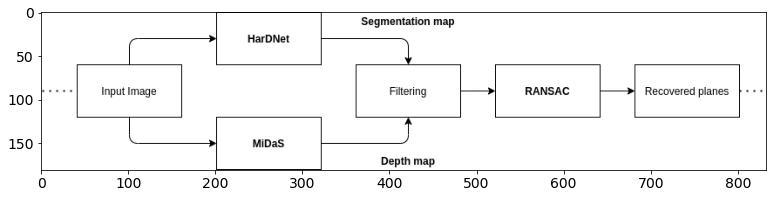

In [12]:
plt.imshow(cv2.cvtColor(cv2.imread("media/schema.png"), cv2.COLOR_BGR2RGB));

### Проблемы, возникшие при реализации

В ходе экспериментов было выявлено слабое звено модели. Им оказалась сегментация. Проблема возникла из-за того, что большинство датасетов для сегментации (уличных) заточены под задачи для self-driving машин, и, следовательно, на снимках в таких датасетах в основном дорога, автомобили и мало зданий, стен, тратуаров и прочего $-$ все то, что встречается у человека на пути по улице. Проблема наглядно.

##### **Исходное изображение**

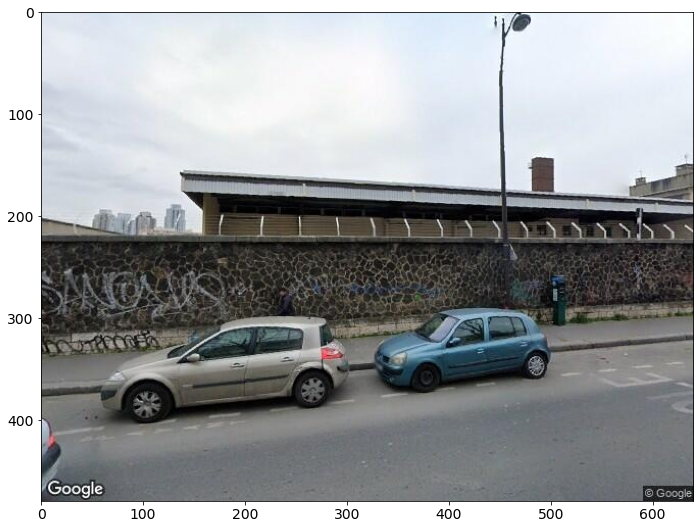

In [13]:
plt.imshow(cv2.cvtColor(cv2.imread("media/segm_example.jpg"), cv2.COLOR_BGR2RGB));

##### **Сегментация (обучено только на Cityscapes)**

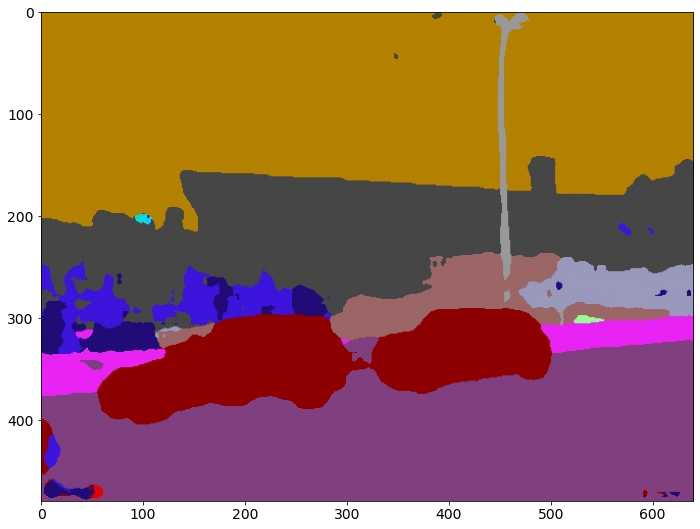

In [14]:
plt.imshow(cv2.cvtColor(cv2.imread("media/bad_segm.jpg"), cv2.COLOR_BGR2RGB));

##### **Сегментация (Дообучено на смеси Cityscapes + Vistas)**

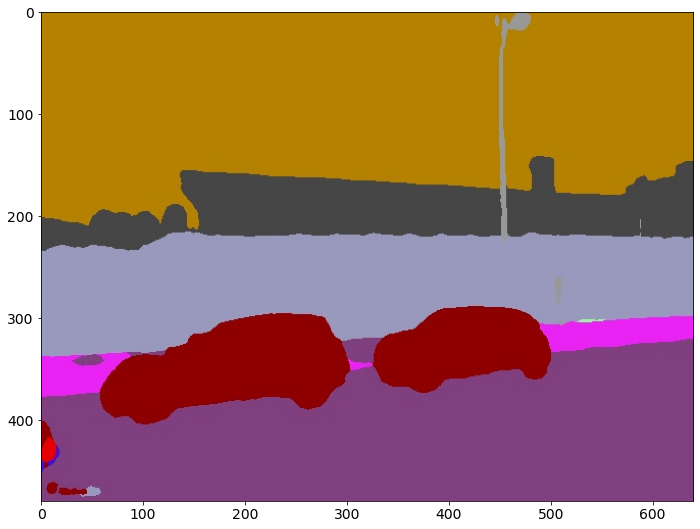

In [15]:
plt.imshow(cv2.cvtColor(cv2.imread("media/good_segment.jpg"), cv2.COLOR_BGR2RGB));

Решить проблему с сегментацией удалось использованием более богатого датасета (Vistas). К сожалению, у него закрытая лицензия и просто так ссылку на него приложить нельзя. У него гораздо больше классов (65 против 19 у Cityscapes), поэтому пришлось вручную на основе здравого смысла сливать некоторые классы в один. Результат дообучения видно сверху. Версия обученной модели лежит в папке `models_pretrained`. 

### Пример работы

Рассмотрим то, как можно с помощью модели построить частичную 3D-сцену для какого-то изображения с улицы.


In [27]:
# инициализация моделей
from models.hardnet_segm import HardNetSegm
import cv2
import torch
from tqdm import tqdm_notebook

from models.bts_estimator import BTSEstimator
from plane_detector import PlaneDetector
from models.midas_estimator import MIDASEstimator
from ransac_detector import *
from process_utils import *


hardnet_path = "models_pretrained/hardnet_alter_checkpoint.pkl"

depth_model = MIDASEstimator()
segm_model = HardNetSegm(hardnet_path)

model = PlaneDetector(depth_model, segm_model)

/home/ruslan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ruslan/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master


In [32]:
img = cv2.imread("test_corner2.jpg")
img = cv2.resize(img, (640, 480))


In [33]:
# построение карты глубины, сегментации и набора масок интересующих областей 
# (для примера здесь 2 набора - дорога и тратуар (0 и 1) и здания (2))
depth_map, seg_map, ls_map_arr = model.get_segmented_depth(img, [{0, 1}, {2}])

In [35]:
# фильтрация и получение более ровных областей
ls_right_depths = []
ls_tmp = []
funcs = [thr_func(0.95), np.mean]
for item, fun in zip(ls_map_arr, funcs):
    tmp, k = crop_depth_map(depth_map * item, fun)
    ls_right_depths.extend(get_connected_components(tmp, threshold=0.3))

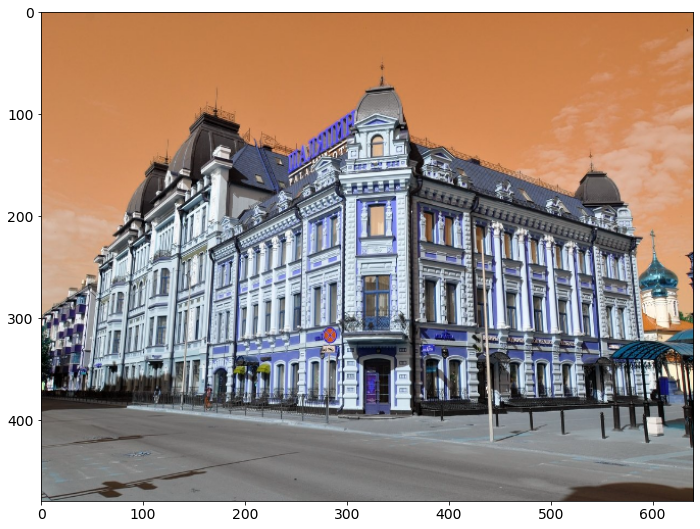

In [39]:
plt.imshow(img);

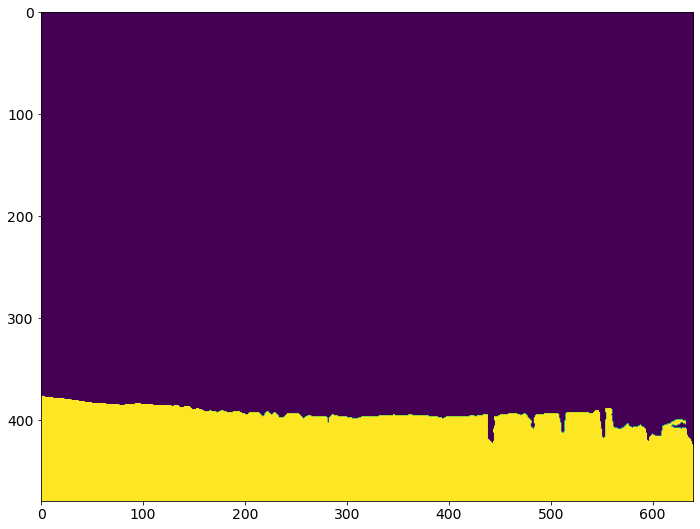

In [40]:
# дорога
plt.imshow(ls_map_arr[0]);

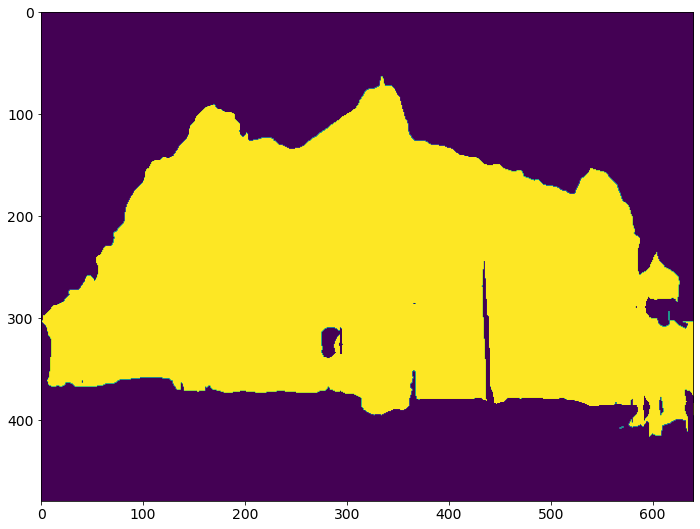

In [41]:
# здание
plt.imshow(ls_map_arr[1]);

In [44]:
# для визуализации используем небольшой питоновский трюк
import open3d as o3d
import sys
import os
# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Извлечение плоскостей, получение их векторов нормали и бинарных масок пикселей

In [46]:
%%time
ls_right_map_arrs = [np.where(item[0] > 0, 1, 0) for item in ls_right_depths]
ls_maps_planes = []
ls_vectors_planes = []
for dd, map_arr in zip(ls_right_depths, ls_right_map_arrs):
    result = extract_planes_con(map_arr, dd[0], map_arr.sum(), 0.2)
    ls_maps_planes.extend([arr for arr, _ in result])
    ls_vectors_planes.extend([arr for _, arr in result])

CPU times: user 274 ms, sys: 3.12 ms, total: 277 ms
Wall time: 279 ms


In [48]:
# один вектор направлен по оси OY, а два других почти перпендикулярны
ls_vectors_planes

[array([ 5.42381254e-02,  9.76814584e-01, -2.07102619e-01,  4.29908995e-05]),
 array([7.26536028e-01, 2.57114306e-01, 6.37210824e-01, 2.90973805e-04]),
 array([ 7.48582479e-01, -2.35764016e-01, -6.19709288e-01, -3.12438135e-04])]

In [49]:
img1 = img.copy()
ls_pcd = []
for item, (a, b, c, d) in zip(ls_maps_planes, ls_vectors_planes):
    tmp = o3d.geometry.Image(np.float32((1 / depth_map) * item))
    tt = o3d.geometry.PointCloud.create_from_depth_image(tmp, DEFAULT_CAM, depth_scale=1.0)
    tt.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    tt.paint_uniform_color([random.uniform(0, 1) for _ in range(3)])
    
    ls_pcd.append(tt)

    indeces = np.argwhere(item)
    color = [random.randint(1, 255) for _ in range(3)]
    for i, j in indeces:
        img1[i][j] = color

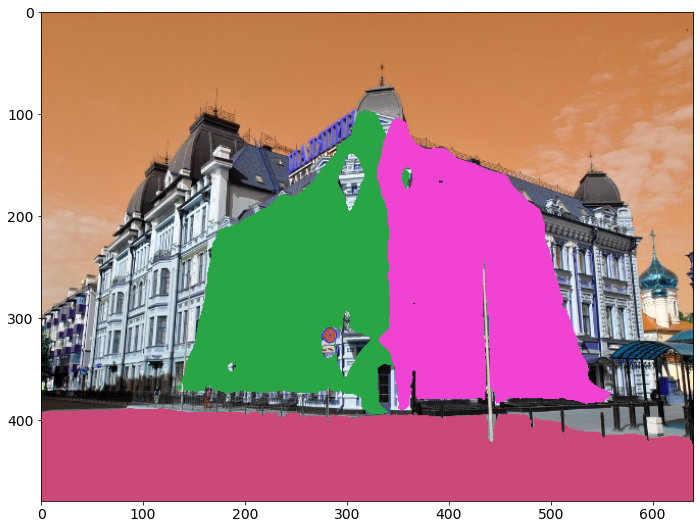

In [51]:
plt.imshow(img1);

In [52]:
# здесь можно посмотреть в 3D облака точек, которые получаются и плоскости построенные
ls_new_pcd = [straight_pcd(close_map(map_arr), 1 / depth_map, plane) for map_arr, plane in zip(ls_maps_planes, ls_vectors_planes)]

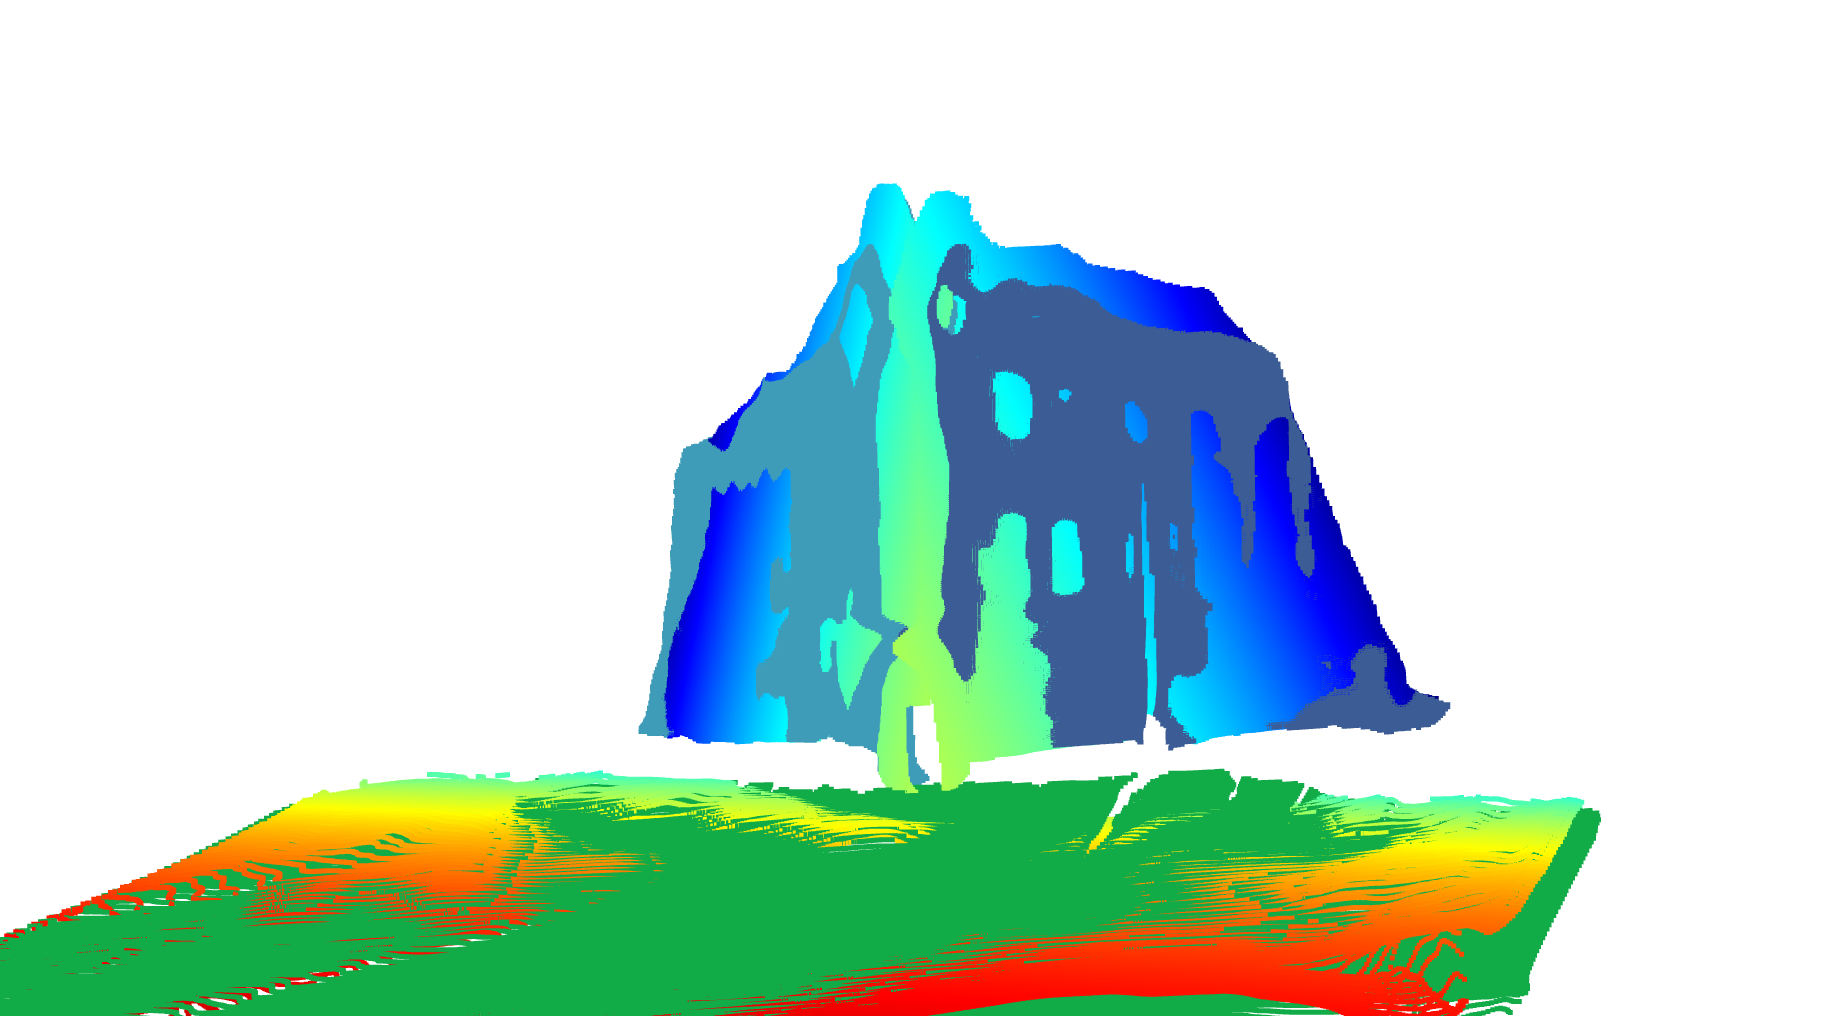

In [53]:
ls_new_pcd.extend(ls_pcd)
o3d.visualization.draw_geometries(ls_new_pcd, zoom=0.35)

Моноцветами обозначены различные части облаков точек, у которых удалось выделить плоскости, соответствующие разным векторам нормали. 
Градиентом выделены плосксоти, которым принадлежат точки